In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import math
import random


# Random polynomial frequency masking

In [2]:
def generate_polynomial_coeff(a_min, a_max):
    """
    Generates a random square polynomial that has a critical point
    that has coordinates (x;y) where 0 < x < 1 and 0 < y < 1
    Returns coefficiants for the polynomial: ax^2 + bx + c where a is in range [a_min; a_max]
    a MUST be positive -> the polynomial ir upright
    """
    # define a range as [a_min;a_max]
    a = random.uniform(a_min, a_max)
    # b must be in range [-2a;0]
    b_min, b_max = -2*a, 0
    b = random.uniform(b_min, b_max)
    tmp = - (b**2)/(4*a) + (b**2)/(2*a)
    c_min = 1 + tmp
    c_max = tmp
    c = random.uniform(c_min, c_max)
    return (a, b, c)

In [3]:
def plot_polynomial(a, b, c, ax, color):
    x = np.linspace(0,1,64)
    y = a*(x**2) + b*x + c
    y[y>1]=1 # clip the function values to the correct range
    rgb = (random.random(), random.random(), random.random())
    ax.plot(x,y, color=rgb)
    

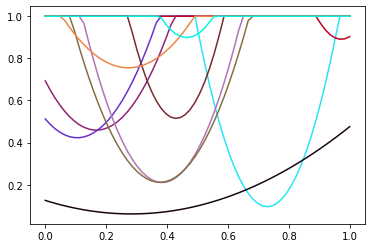

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(10):
    a,b,c = generate_polynomial_coeff(0, 20)
    plot_polynomial(a, b, c, ax, i)
    x_sol = -b/(2*a)
    y_sol = a*(x_sol**2) + b*x_sol + c
    if x_sol < 0 or x_sol > 1 or y_sol < 0 or y_sol > 1:
        print(f"Error P: {a}x^2 + {b}x + {c} -> critical point at: ({x_sol}; {y_sol})")

# show the plot
plt.show()


In [5]:
def generate_non_differentiable_mask(start, stop, steps, polynomials):
    x = np.linspace(start, stop, steps)
    y = np.ones_like(x)
    for i in range(polynomials):
        a,b,c = generate_polynomial_coeff(0, 20)
        poly_y = a*(x**2) + b*x + c
        poly_y[poly_y>1] = 1
        y = np.minimum(y, poly_y)
    return y

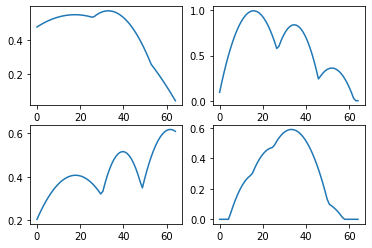

In [6]:
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)

    x = np.linspace(0,64,64)
    y = 1- generate_non_differentiable_mask(0, 1, 64, 5)
    ax.plot(x,y)

In [7]:
# brute-force correctness validation
for i in range(100000):
    a,b,c = generate_polynomial_coeff(0, 10000)
    x_sol = -b/(2*a)
    y_sol = a*(x_sol**2) + b*x_sol + c
    if x_sol < 0 or x_sol > 1 or y_sol < 0 or y_sol > 1:
        print(f"Incorrect P: {a}x^2 + {b}x + {c} -> critical point at: ({x_sol}; {y_sol})")
        b_in_range = b < 0 and b > (-2*a)
        c_in_range = 0 < (((b**2)/(4*a)) - ((b**2)/(2*a)) + c) and 1 > (((b**2)/(4*a)) - ((b**2)/(2*a)) + c)
        print(f"b in range: {b_in_range}, c in range: {c_in_range}")

In [8]:
import torch
# test application to spectrogram in batch form: (batch_size, channel_count, height, width)
spectrogram = torch.ones(2, 1, 3, 5)
multiplier = torch.ones_like(spectrogram)
# iterate over batches
spec_height = spectrogram.shape[-2]
spec_width = spectrogram.shape[-1]
for i, spectrogram_item in enumerate(spectrogram):
    (a, b, c) = generate_polynomial_coeff(0, 20)
#     (a, b, c) = (0, 1, 0)
    sampling_x = torch.linspace(0,1, spec_height)
    filter_samples_y = a*(torch.pow(sampling_x, 2)) + b*sampling_x + c
    filter_samples_y[filter_samples_y > 1] = 1
    spectrogram_item_multiplier = filter_samples_y.view((spec_height, 1)).repeat((1, spec_width)).view(1, spec_height, spec_width)
    multiplier[i] = spectrogram_item_multiplier
# inverse cut:
multiplier = 1 - multiplier
print("mock spectrogram:")
display(spectrogram)
print("Poly mask:")
display(multiplier)
spectrogram = spectrogram*multiplier
print("Masked spectrogram:")
display(spectrogram)

mock spectrogram:


tensor([[[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]]])

Poly mask:


tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0005, 0.0005, 0.0005, 0.0005, 0.0005]]],


        [[[0.3337, 0.3337, 0.3337, 0.3337, 0.3337],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]])

Masked spectrogram:


tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0005, 0.0005, 0.0005, 0.0005, 0.0005]]],


        [[[0.3337, 0.3337, 0.3337, 0.3337, 0.3337],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]])

# FRF Modeling

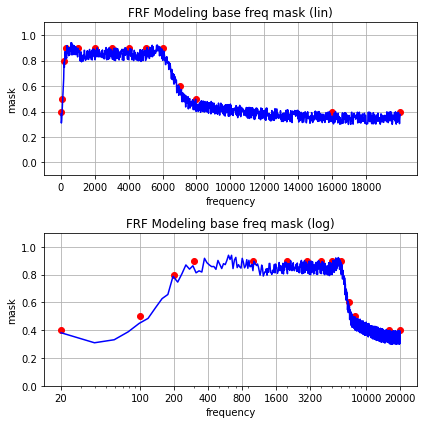

In [9]:
from matplotlib.ticker import ScalarFormatter
from scipy import interpolate

samples = 1024 
x = np.linspace(20, 20000, samples)
x_val = np.linspace(0, 1, samples)
y = 1 - (x_val)**4

points = [
    (20, 0.4),
    (100, 0.5),
    (200, 0.8),
    (300, 0.9),
    (1000, 0.9),
    (2000, 0.9),
    (3000, 0.9),
    (4000, 0.9),
    (5000, 0.9),
    (6000, 0.9),
    (7000, 0.6),
    (8000, 0.5),
    (16000, 0.4),
    (20000, 0.4),
]
p = np.array(points)
x_p, y_p = p[:,0], p[:, 1]
freq_mask_f = interpolate.interp1d(x_p, y_p, kind='cubic')

ynew = freq_mask_f(x)
ynew -= np.random.rand(ynew.shape[0])*0.1

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(2, 1, 1)
ax.set_title("FRF Modeling base freq mask (lin)")
ax.set_xscale('linear')
ax.set_xlabel('frequency')
ax.set_ylabel('mask')
ax.set_ylim(-0.1, 1.1)
ticks = [x*2000 for x in range(10)]
ax.set_xticks(ticks)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.grid(True)
ax.plot(x_p, y_p, 'ro')
ax.plot(x, ynew, 'b-')

ax = fig.add_subplot(2, 1, 2)
ax.set_title("FRF Modeling base freq mask (log)")
ax.set_xscale('log')
ax.set_xlabel('frequency')
ax.set_ylabel('mask')
ax.set_ylim(-0.0, 1.1)
ticks = [20] + [100*(2**i) for i in range(6)] + [10000, 20000]
ax.set_xticks(ticks)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.grid(True)
ax.plot(x_p, y_p, 'ro')
ax.plot(x, ynew, 'b-')

plt.tight_layout()


array([[2.0e+01, 1.0e-01],
       [1.0e+02, 1.0e-01],
       [1.0e+03, 9.0e-01],
       [1.1e+03, 9.0e-01],
       [1.2e+03, 9.0e-01],
       [2.0e+03, 9.0e-01],
       [3.0e+03, 9.0e-01],
       [4.0e+03, 9.0e-01],
       [5.0e+03, 9.0e-01],
       [6.0e+03, 9.0e-01],
       [7.0e+03, 9.0e-01],
       [6.9e+03, 9.0e-01],
       [8.0e+03, 5.0e-01],
       [9.0e+03, 1.0e-01],
       [1.2e+04, 4.0e-01],
       [1.5e+04, 4.0e-01],
       [1.8e+04, 4.0e-01],
       [2.1e+04, 4.0e-01]])

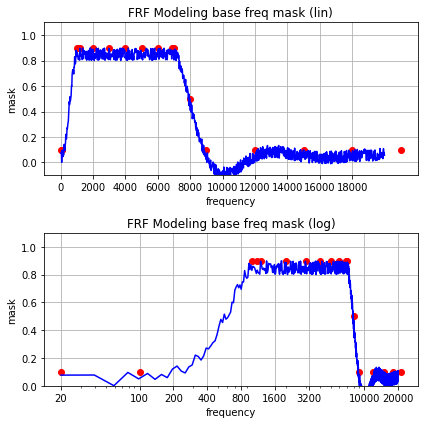

In [39]:
start_mask_freq = 1000
end_mask_freq = 7000

points = [
#     (0, 0.4),
    (20, 0.1),
    (100, 0.1),
    (start_mask_freq, 0.9),
    (start_mask_freq + 100, 0.9),
    (start_mask_freq + 200, 0.9),
]
freq = start_mask_freq
while freq < end_mask_freq - 100:
    freq += 1000
    points.append((freq, 0.9))
points.extend([
    (end_mask_freq - 100, 0.9),
    (end_mask_freq + 1000, 0.5),
    (end_mask_freq + 2000, 0.1),
])
freq = end_mask_freq + 2000
while freq < 20000:
    freq += 3000
    points.append((freq, 0.1))
display(p)
p = np.array(points)
x_p, y_p = p[:,0], p[:, 1]
freq_mask_f = interpolate.interp1d(x_p, y_p, kind='cubic')

ynew = freq_mask_f(x)
ynew -= np.random.rand(ynew.shape[0])*0.1

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(2, 1, 1)
ax.set_title("FRF Modeling base freq mask (lin)")
ax.set_xscale('linear')
ax.set_xlabel('frequency')
ax.set_ylabel('mask')
ax.set_ylim(-0.1, 1.1)
ticks = [x*2000 for x in range(10)]
ax.set_xticks(ticks)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.grid(True)
ax.plot(x_p, y_p, 'ro')
ax.plot(x, ynew, 'b-')

ax = fig.add_subplot(2, 1, 2)
ax.set_title("FRF Modeling base freq mask (log)")
ax.set_xscale('log')
ax.set_xlabel('frequency')
ax.set_ylabel('mask')
ax.set_ylim(-0.0, 1.1)
ticks = [20] + [100*(2**i) for i in range(6)] + [10000, 20000]
ax.set_xticks(ticks)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.grid(True)
ax.plot(x_p, y_p, 'ro')
ax.plot(x, ynew, 'b-')

plt.tight_layout()

In [37]:
import torch

def test_f(x):
    return x

def apply_mic_mask(spectrogram: torch.Tensor, mask_start_freq: int, mask_end_freq: int):
    points = [
        (0, 0.4),
        (20, 0.4),
        (100, 0.5),
        (mask_start_freq, 0.9),
        (mask_start_freq + 100, 0.9),
        (mask_start_freq + 200, 0.9),
    ]
    freq = mask_start_freq
    while freq < mask_end_freq - 100:
        freq += 1000
        points.append((freq, 0.9))
    points.extend([
        (mask_end_freq - 100, 0.9),
        (mask_end_freq + 1000, 0.5),
        (mask_end_freq + 2000, 0.4),
    ])
    freq = mask_end_freq + 2000
    while freq < 20000:
        freq += 3000
        points.append((freq, 0.4))
    p = np.array(points)
    x_p, y_p = (p[:,0]/20000), p[:, 1]
    display(x_p, y_p)
    freq_mask_f = interpolate.interp1d(x_p, y_p, kind='cubic')
    freq_mask_f = test_f
    x = np.linspace(0.001, 1, spectrogram.shape[-2])
    mask_samples = freq_mask_f(x)
    mask_samples = torch.Tensor(mask_samples)
    print(f"Maks samples: {mask_samples}")
    mask_samples = mask_samples.view(-1, 1)
    print(f"Mask broadcasted: {mask_samples}")
    print(f"Spectrogram batch before multiplication: {spectrogram}")
    spectrogram = spectrogram * mask_samples
    print(f"Spectrogram after multiplication: {spectrogram}")
    
    

# test application to spectrogram in batch form: (batch_size, channel_count, height, width)
spectrogram = torch.ones(2, 1, 3, 5)
apply_mic_mask(spectrogram, 200, 5000)

array([0.00e+00, 1.00e-03, 5.00e-03, 1.00e-02, 1.50e-02, 2.00e-02,
       6.00e-02, 1.10e-01, 1.60e-01, 2.10e-01, 2.60e-01, 2.45e-01,
       3.00e-01, 3.50e-01, 5.00e-01, 6.50e-01, 8.00e-01, 9.50e-01,
       1.10e+00])

array([0.4, 0.4, 0.5, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.5,
       0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

Maks samples: tensor([0.0010, 0.5005, 1.0000])
Mask broadcasted: tensor([[0.0010],
        [0.5005],
        [1.0000]])
Spectrogram batch before multiplication: tensor([[[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]]])
Spectrogram after multiplication: tensor([[[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.5005, 0.5005, 0.5005, 0.5005, 0.5005],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]],


        [[[0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
          [0.5005, 0.5005, 0.5005, 0.5005, 0.5005],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]]])
